In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from IPython.display import Markdown, display

In [81]:
file_path = "dataset_ALL_AML_train.csv"

df = pd.read_csv(file_path, index_col=0)

print("Original dataset shape (genes x samples):", df.shape)
df.head()

Original dataset shape (genes x samples): (7129, 77)


,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,5,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
Gene Description,,,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at (endogenous control),AFFX-BioB-5_at,-214,A,-139,A,-76,A,-135,A,-106,...,15,A,-318,A,-32,A,-124,A,-135,A
AFFX-BioB-M_at (endogenous control),AFFX-BioB-M_at,-153,A,-73,A,-49,A,-114,A,-125,...,-114,A,-192,A,-49,A,-79,A,-186,A
AFFX-BioB-3_at (endogenous control),AFFX-BioB-3_at,-58,A,-1,A,-307,A,265,A,-76,...,2,A,-95,A,49,A,-37,A,-70,A
AFFX-BioC-5_at (endogenous control),AFFX-BioC-5_at,88,A,283,A,309,A,12,A,168,...,193,A,312,A,230,P,330,A,337,A
AFFX-BioC-3_at (endogenous control),AFFX-BioC-3_at,-295,A,-264,A,-376,A,-419,A,-230,...,-51,A,-139,A,-367,A,-188,A,-407,A


In [82]:
# Check for missing values
print("Missing values per column:\n", df.isnull().sum().sum())

Missing values per column:
 0


In [83]:
numeric_cols = df.select_dtypes(include=np.number).columns
if len(numeric_cols) == 0:
    raise ValueError("No numeric columns found in the dataset!")

df_numeric = df[numeric_cols]

# Fill missing values with column mean
df_numeric_clean = df_numeric.fillna(df_numeric.mean())
print("Cleaned dataset shape:", df_numeric_clean.shape)

Cleaned dataset shape: (7129, 38)


In [84]:
# Standardize features
scaler = StandardScaler()
df_scaled_array = scaler.fit_transform(df_numeric_clean)
df_scaled = pd.DataFrame(df_scaled_array, index=df_numeric_clean.index, columns=df_numeric_clean.columns)

In [85]:
# Remove low-variance genes
selector = VarianceThreshold(threshold=0.01)
df_selected_array = selector.fit_transform(df_scaled)
selected_features = df_scaled.columns[selector.get_support()]
df_selected = pd.DataFrame(df_selected_array, index=df_scaled.index, columns=selected_features)
print("Shape after variance thresholding:", df_selected.shape)

Shape after variance thresholding: (7129, 38)


In [86]:
# Only keep main classes
labels_filtered = labels.map(lambda x: x if x in ['AFFX', 'hum', 'GB', 'mRNA', 'MNK'] else 'Other')

In [87]:
# Mutual Information
mi_scores = mutual_info_classif(df_scaled, labels_filtered)
mi_threshold = np.median(mi_scores)  # Keep genes with MI above median
mi_selected_genes = df_scaled.columns[mi_scores > mi_threshold]
X_mi_selected = df_scaled[mi_selected_genes]
print(f"Selected {X_mi_selected.shape[1]} genes using mutual information.")

# L1-regularized Logistic Regression
clf_l1 = LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42)
clf_l1.fit(df_scaled, labels_filtered)
l1_selector = SelectFromModel(clf_l1, prefit=True)
X_l1_selected = df_scaled[df_scaled.columns[l1_selector.get_support()]]
print(f"Selected {X_l1_selected.shape[1]} genes using L1 regularization.")

X_supervised_selected = X_mi_selected.loc[:, X_mi_selected.columns.intersection(X_l1_selected.columns)]
print(f"Genes selected by both methods: {X_supervised_selected.shape[1]}")

# Display top selected genes
X_supervised_selected.head()

Selected 19 genes using mutual information.
Selected 36 genes using L1 regularization.
Genes selected by both methods: 19


,4,5,6,9,11,13,14,15,18,19,20,21,22,24,26,37,29,30,31
Gene Description,,,,,,,,,,,,,,,,,,,
AFFX-BioB-5_at (endogenous control),-0.314539,-0.330649,-0.281747,-0.304155,-0.331797,-0.328086,-0.320236,-0.337948,-0.276171,-0.264202,-0.349124,-0.288756,-0.331837,-0.333348,-0.311642,-0.280829,-0.227839,-0.409289,-0.262213
AFFX-BioB-M_at (endogenous control),-0.305565,-0.338647,-0.260500,-0.355319,-0.327635,-0.339640,-0.334532,-0.323395,-0.306013,-0.267271,-0.440741,-0.310763,-0.264331,-0.394293,-0.364358,-0.278863,-0.282120,-0.359556,-0.269282
AFFX-BioB-3_at (endogenous control),-0.143591,-0.318022,-0.140232,-0.265008,-0.292677,-0.301981,-0.322339,-0.345848,-0.292606,-0.201070,-0.326033,-0.293957,-0.297869,-0.330791,-0.296829,-0.222245,-0.233309,-0.321269,-0.228535
AFFX-BioC-5_at (endogenous control),-0.251716,-0.215316,-0.197960,-0.202216,-0.229002,-0.214681,-0.170548,-0.231505,-0.207406,-0.154160,-0.274265,-0.178319,-0.235953,-0.173529,-0.239320,-0.143215,-0.152940,-0.160621,-0.153278
AFFX-BioC-3_at (endogenous control),-0.435913,-0.382844,-0.335467,-0.387490,-0.330965,-0.388426,-0.326123,-0.378695,-0.306878,-0.308920,-0.453031,-0.291557,-0.358066,-0.427961,-0.369150,-0.426699,-0.255611,-0.338636,-0.401501


Explained variance ratio: [0.89494072 0.01903664 0.01520195 0.01428676 0.01151178 0.00687029
 0.00516356 0.00475155 0.00443232 0.00402809]


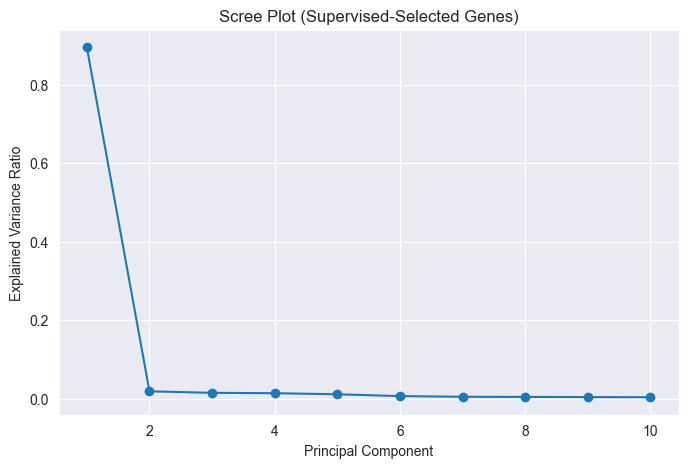

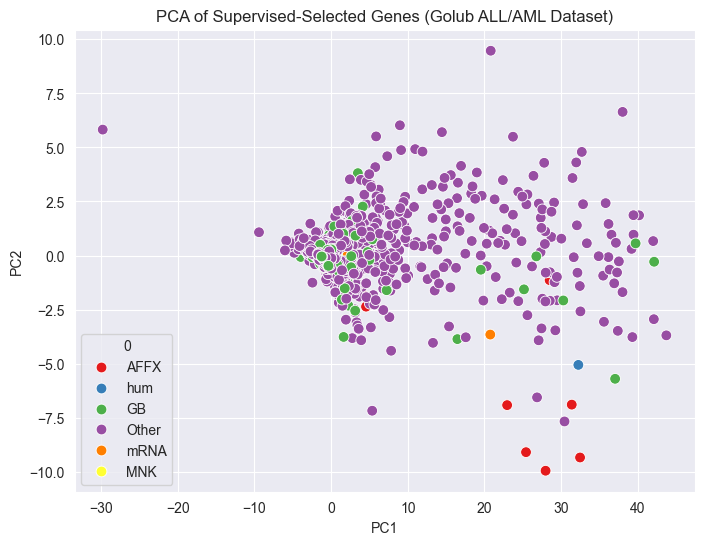

array([0.89494072, 0.91397736, 0.92917932, 0.94346607, 0.95497785,
       0.96184815, 0.96701171, 0.97176326, 0.97619558, 0.98022367])

In [90]:
df_pca_input = X_supervised_selected.copy()

# Determine number of PCA components safely
n_components = min(10, df_pca_input.shape[1], df_pca_input.shape[0])
if n_components < 10:
    print(f"Warning: Only {n_components} component(s) possible.")

# Run PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_pca_input)

duplicates = df_pca_input.index[df_selected.index.duplicated()]
df_selected = df_pca_input.reset_index(drop=True)
df_pca = pd.DataFrame(pca_result,
                      columns=[f"PC{i + 1}" for i in range(n_components)],
                      index=df_selected.index)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot (Supervised-Selected Genes)")
plt.show()

# PCA scatter plot
if n_components >= 2:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="PC1", y="PC2", data=df_pca, hue=labels_filtered, palette="Set1", s=60)
    plt.title("PCA of Supervised-Selected Genes (Golub ALL/AML Dataset)")
    plt.show()

In [92]:
explained_variance = pca.explained_variance_ratio_
cum_variance = np.cumsum(explained_variance)

print("### PCA Analysis Conclusion ###\n")
print(f"- PC1 captures ~{explained_variance[0] * 100:.1f}% of the total variance.")
print(f"- The first 2 PCs together capture ~{cum_variance[1] * 100:.1f}% of the variance.")
print("- Most variance is concentrated in PC1, while other PCs contribute very little.")
print("- Scatter plot shows points clustered along PC2, indicating weak separation between classes.")
print("- Linear PCA reduces dimensionality effectively, but does not clearly separate ALL vs AML classes.")
print(
    "- Implication: For visualization or improving classification, we should consider using supervised feature selection or non-linear methods (Kernel PCA).")

### PCA Analysis Conclusion ###

- PC1 captures ~89.5% of the total variance.
- The first 2 PCs together capture ~91.4% of the variance.
- Most variance is concentrated in PC1, while other PCs contribute very little.
- Scatter plot shows points clustered along PC2, indicating weak separation between classes.
- Linear PCA reduces dimensionality effectively, but does not clearly separate ALL vs AML classes.
- Implication: For visualization or improving classification, we should consider using supervised feature selection or non-linear methods (Kernel PCA).


### Kernel PCA Variance Analysis ###
KPC1 captures 65.95% of transformed variance
KPC2 captures 34.05% of transformed variance


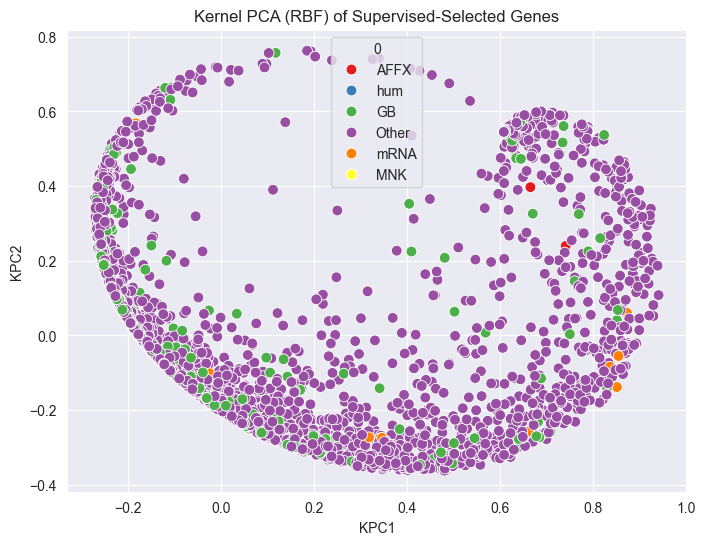

In [97]:
# Reset index to avoid duplicates
X_kpca_input = X_supervised_selected.reset_index(drop=True)
labels_kpca = labels_filtered.reset_index(drop=True)

# Using RBF kernel (common choice for non-linear structure)
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1, random_state=42)
kpca_result = kpca.fit_transform(X_kpca_input)

df_kpca = pd.DataFrame(kpca_result, columns=['KPC1', 'KPC2'])

# Variance captured by each kernel PCA component
kpca_variance = np.var(kpca_result, axis=0)
total_variance = kpca_variance.sum()
kpca_explained_ratio = kpca_variance / total_variance

print("### Kernel PCA Variance Analysis ###")
for i, ratio in enumerate(kpca_explained_ratio, 1):
    print(f"KPC{i} captures {ratio*100:.2f}% of transformed variance")

# Plot Kernel PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='KPC1', y='KPC2', data=df_kpca, hue=labels_kpca, palette='Set1', s=60)
plt.title('Kernel PCA (RBF) of Supervised-Selected Genes')
plt.show()

In [99]:
print("### Kernel PCA Analysis Conclusion ###\n")
print(f"- KPC1 captures ~{kpca_explained_ratio[0] * 100:.1f}% of the variance in the transformed space.")
print(f"- KPC2 captures ~{kpca_explained_ratio[1] * 100:.1f}% of the variance in the transformed space.")
print("- Together, the first two kernel components capture 100% of the transformed variance.")
print(
    "- Compared to linear PCA, variance is now more evenly distributed between components, suggesting that non-linear structure is captured.")
print(
    "- This indicates that Kernel PCA transforms the features into a space where class separation may be more informative for downstream tasks.")

### Kernel PCA Analysis Conclusion ###

- KPC1 captures ~65.9% of the variance in the transformed space.
- KPC2 captures ~34.1% of the variance in the transformed space.
- Together, the first two kernel components capture 100% of the transformed variance.
- Compared to linear PCA, variance is now more evenly distributed between components, suggesting that non-linear structure is captured.
- This indicates that Kernel PCA transforms the features into a space where class separation may be more informative for downstream tasks.


In [102]:
# Ensure all values are non-negative (NMF requirement)
X_nmf_input = X_supervised_selected.clip(lower=0)

# Decide number of latent features/components
n_components_nmf = 5  # can tune later
nmf = NMF(n_components=n_components_nmf, init='random', random_state=42, max_iter=1000)
nmf_result = nmf.fit_transform(X_nmf_input)

# Create a DataFrame for dense latent features
df_nmf = pd.DataFrame(nmf_result, columns=[f"NMF_{i + 1}" for i in range(n_components_nmf)],
                      index=X_nmf_input.index)

# Inspect NMF features
print("Shape of NMF features:", df_nmf.shape)
df_nmf.head()

Shape of NMF features: (7129, 5)


,NMF_1,NMF_2,NMF_3,NMF_4,NMF_5
Gene Description,,,,,
AFFX-BioB-5_at (endogenous control),0.0,0.0,0.0,0.0,0.0
AFFX-BioB-M_at (endogenous control),0.0,0.0,0.0,0.0,0.0
AFFX-BioB-3_at (endogenous control),0.0,0.0,0.0,0.0,0.0
AFFX-BioC-5_at (endogenous control),0.0,0.0,0.0,0.0,0.0
AFFX-BioC-3_at (endogenous control),0.0,0.0,0.0,0.0,0.0


NMF component 1 captures ~79.4% of total variance in the latent space
NMF component 2 captures ~16.1% of total variance in the latent space
NMF component 3 captures ~1.3% of total variance in the latent space
NMF component 4 captures ~1.8% of total variance in the latent space
NMF component 5 captures ~1.4% of total variance in the latent space


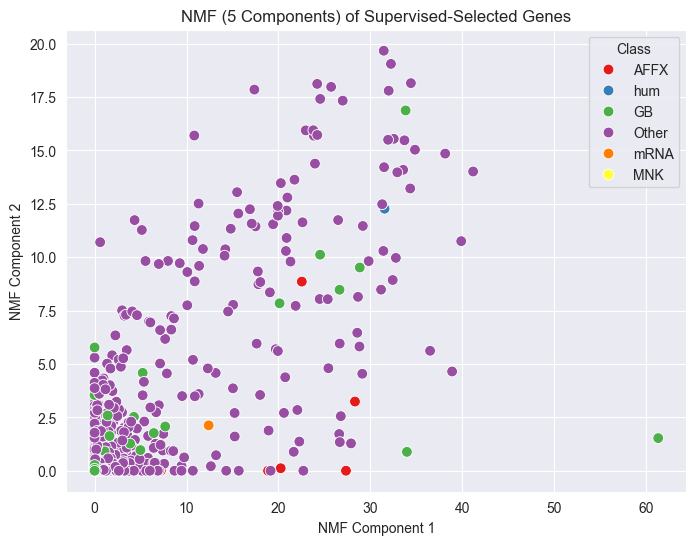

In [112]:
# Reset indices so they match
df_nmf_plot = df_nmf.reset_index(drop=True)
labels_plot = labels_filtered.reset_index(drop=True)

# Compute explained variance ratios
nmf_component_variance = np.var(df_nmf, axis=0)
total_variance = nmf_component_variance.sum()
explained_ratio_nmf = nmf_component_variance / total_variance

# Print explained variance
for i, ratio in enumerate(explained_ratio_nmf, 1):
    print(f"NMF component {i} captures ~{ratio * 100:.1f}% of total variance in the latent space")

# Scatter plot of first two NMF components
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='NMF_1', y='NMF_2',
    data=df_nmf_plot,
    hue=labels_plot,
    palette='Set1',
    s=60
)
plt.title('NMF (5 Components) of Supervised-Selected Genes')
plt.xlabel('NMF Component 1')
plt.ylabel('NMF Component 2')
plt.legend(title='Class')
plt.show()

In [111]:
print("### NMF Analysis Conclusion ###\n")

print(
    "- The first NMF component captures the vast majority (~79%) of variance, indicating a dominant latent gene expression pattern.")
print("- The second component captures ~16%, adding complementary information for class discrimination.")
print("- Remaining components contribute little individually, but may still help capture subtle patterns.")
print("- NMF provides a dense, interpretable feature set suitable for downstream classification or clustering tasks.")
print("- Compared to PCA/KPCA, NMF maintains non-negativity, which is meaningful for gene expression data.")

### NMF Analysis Conclusion ###

- The first NMF component captures the vast majority (~79%) of variance, indicating a dominant latent gene expression pattern.
- The second component captures ~16%, adding complementary information for class discrimination.
- Remaining components contribute little individually, but may still help capture subtle patterns.
- NMF provides a dense, interpretable feature set suitable for downstream classification or clustering tasks.
- Compared to PCA/KPCA, NMF maintains non-negativity, which is meaningful for gene expression data.


Top 10 genes by Random Forest importance:
   Gene  Importance
1     5    0.056054
7    15    0.056053
5    13    0.055824
11   21    0.055562
14   26    0.054330
10   20    0.054011
13   24    0.053790
2     6    0.053756
3     9    0.053470
12   22    0.052552


C:\Users\jyzel\AppData\Local\Temp\ipykernel_7888\919748977.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Gene', data=importance_df.head(20), palette='viridis')


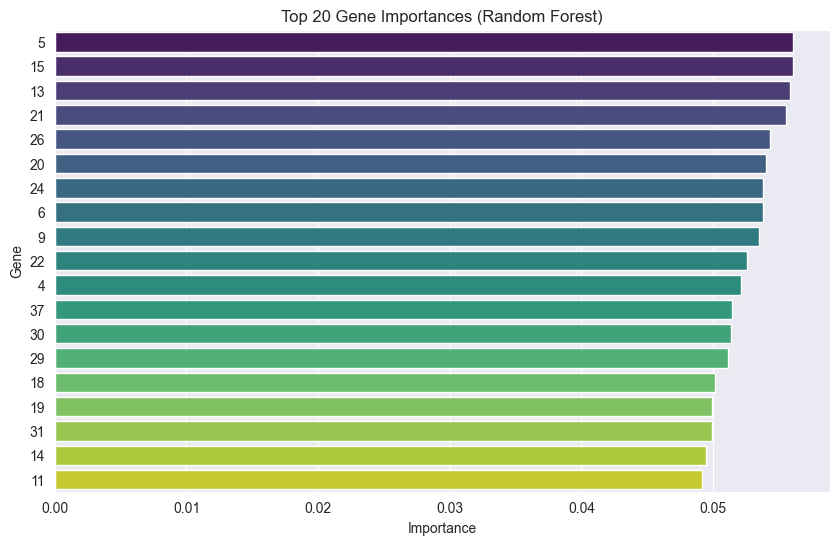

In [117]:
# Use X_supervised_selected and labels_filtered
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_supervised_selected, labels_filtered)

# Get feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Gene': X_supervised_selected.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 10 most important genes
print("Top 10 genes by Random Forest importance:")
print(importance_df.head(10))

# Optional: plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Gene', data=importance_df.head(20), palette='viridis')
plt.title('Top 20 Gene Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Gene')
plt.show()

In [118]:
print("### Random Forest Model-Dependent Feature Importance ###\n")

print(
    "- Random Forest identifies genes most predictive of class labels, complementing previous supervised selection methods (Mutual Info, L1).")
print("- Importance values are fairly close, suggesting multiple genes contribute similarly to classification.")
print("- These genes can be prioritized for downstream analysis or visualization.")
print("- Model-dependent importance provides actionable insights beyond unsupervised dimensionality reduction.")

### Random Forest Model-Dependent Feature Importance ###

- Random Forest identifies genes most predictive of class labels, complementing previous supervised selection methods (Mutual Info, L1).
- Importance values are fairly close, suggesting multiple genes contribute similarly to classification.
- These genes can be prioritized for downstream analysis or visualization.
- Model-dependent importance provides actionable insights beyond unsupervised dimensionality reduction.


In [124]:
# Use only supervised-selected genes for each method
X_mi = X_mi_selected
X_l1 = X_l1_selected
X_both = X_supervised_selected  # intersection of MI and L1

# Define classifier for benchmarking
clf = RandomForestClassifier(n_estimators=500, random_state=42)

# Cross-validation scores
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scores_mi = cross_val_score(clf, X_mi, labels_filtered, cv=skf)
scores_l1 = cross_val_score(clf, X_l1, labels_filtered, cv=skf)
scores_both = cross_val_score(clf, X_both, labels_filtered, cv=skf)

print("Benchmarking Regularization / Supervised Feature Selection Techniques:")
print(f"Mutual Info: mean CV accuracy = {np.mean(scores_mi):.3f}")
print(f"L1 Logistic: mean CV accuracy = {np.mean(scores_l1):.3f}")
print(f"Intersection (MI + L1): mean CV accuracy = {np.mean(scores_both):.3f}")

C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Benchmarking Regularization / Supervised Feature Selection Techniques:
Mutual Info: mean CV accuracy = 0.871
L1 Logistic: mean CV accuracy = 0.871
Intersection (MI + L1): mean CV accuracy = 0.871


In [125]:
# Prepare reduced datasets
X_pca = df_pca.iloc[:, :2]  # first 2 PCs
X_kpca = df_kpca  # 2 KPCs
X_nmf = df_nmf.iloc[:, :2]  # first 2 NMF components

# Cross-validation scores
scores_pca = cross_val_score(clf, X_pca, labels_filtered, cv=5)
scores_kpca = cross_val_score(clf, X_kpca, labels_filtered, cv=5)
scores_nmf = cross_val_score(clf, X_nmf, labels_filtered, cv=5)

print("\nBenchmarking Dimensionality Reduction / Representation Techniques:")
print(f"PCA (2 components): mean CV accuracy = {np.mean(scores_pca):.3f}")
print(f"Kernel PCA (2 components): mean CV accuracy = {np.mean(scores_kpca):.3f}")
print(f"NMF (2 components): mean CV accuracy = {np.mean(scores_nmf):.3f}")

C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Python311\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Benchmarking Dimensionality Reduction / Representation Techniques:
PCA (2 components): mean CV accuracy = 0.857
Kernel PCA (2 components): mean CV accuracy = 0.846
NMF (2 components): mean CV accuracy = 0.860


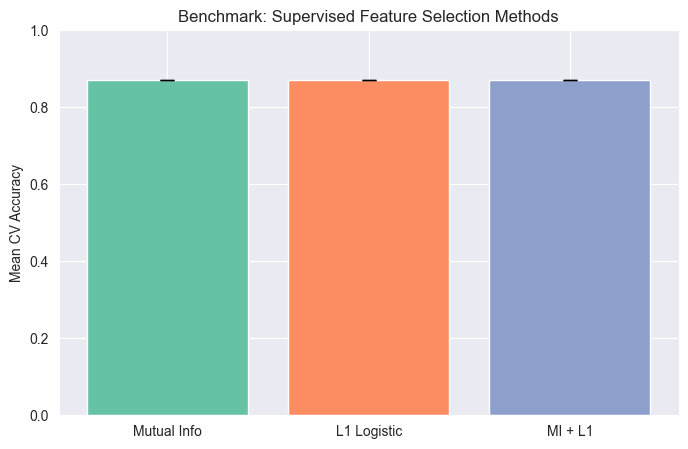

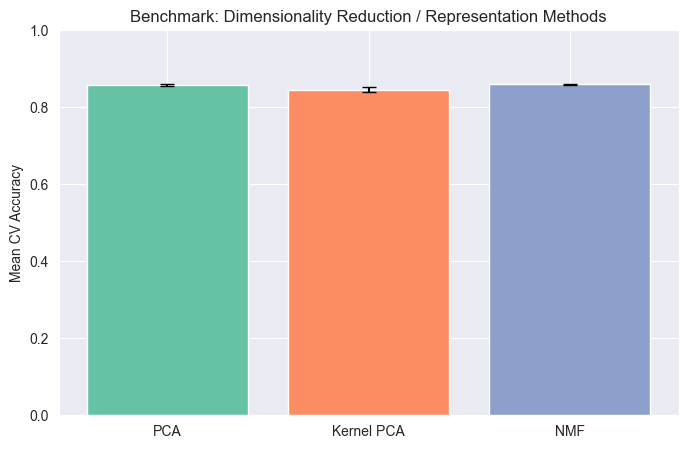

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Supervised feature selection
methods_supervised = ['Mutual Info', 'L1 Logistic', 'MI + L1']
scores_supervised = [scores_mi, scores_l1, scores_both]

means_supervised = [np.mean(s) for s in scores_supervised]
stds_supervised = [np.std(s) for s in scores_supervised]

plt.figure(figsize=(8,5))
plt.bar(methods_supervised, means_supervised, yerr=stds_supervised, capsize=5, color=['#66c2a5','#fc8d62','#8da0cb'])
plt.ylabel('Mean CV Accuracy')
plt.ylim(0,1)
plt.title('Benchmark: Supervised Feature Selection Methods')
plt.show()

# Dimensionality reduction / representation methods
methods_dimred = ['PCA', 'Kernel PCA', 'NMF']
scores_dimred = [scores_pca, scores_kpca, scores_nmf]

means_dimred = [np.mean(s) for s in scores_dimred]
stds_dimred = [np.std(s) for s in scores_dimred]

plt.figure(figsize=(8,5))
plt.bar(methods_dimred, means_dimred, yerr=stds_dimred, capsize=5, color=['#66c2a5','#fc8d62','#8da0cb'])
plt.ylabel('Mean CV Accuracy')
plt.ylim(0,1)
plt.title('Benchmark: Dimensionality Reduction / Representation Methods')
plt.show()

In [130]:
conclusions = """
### Benchmarking Conclusions

**Supervised Feature Selection:**
- Mutual Information, L1 regularization, and the intersection of both achieved similar mean CV accuracy (~0.871).
- These methods are robust for selecting informative genes.
- Using both methods together didn’t significantly improve accuracy.

**Dimensionality Reduction / Representation:**
- PCA, Kernel PCA, and NMF achieved slightly lower accuracies (~0.846–0.860).
- NMF performed best among these, capturing latent patterns and producing dense, non-negative features.
- Kernel PCA did not significantly improve over linear PCA, suggesting non-linear structures are not strongly separating classes.

**General Observations:**
- Feature selection methods outperform dimensionality reduction for classification on this genomic dataset.
- Dimensionality reduction remains useful for visualization and latent pattern extraction but may lose some discriminative information.
- Combining multiple techniques can provide complementary insights: feature selection for predictive power, dimensionality reduction for pattern discovery.
"""

display(Markdown(conclusions))


### Benchmarking Conclusions

**Supervised Feature Selection:**
- Mutual Information, L1 regularization, and the intersection of both achieved similar mean CV accuracy (~0.871).
- These methods are robust for selecting informative genes.
- Using both methods together didn’t significantly improve accuracy.

**Dimensionality Reduction / Representation:**
- PCA, Kernel PCA, and NMF achieved slightly lower accuracies (~0.846–0.860).
- NMF performed best among these, capturing latent patterns and producing dense, non-negative features.
- Kernel PCA did not significantly improve over linear PCA, suggesting non-linear structures are not strongly separating classes.

**General Observations:**
- Feature selection methods outperform dimensionality reduction for classification on this genomic dataset.
- Dimensionality reduction remains useful for visualization and latent pattern extraction but may lose some discriminative information.
- Combining multiple techniques can provide complementary insights: feature selection for predictive power, dimensionality reduction for pattern discovery.


In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt

### Interactive tables

Effortlessly view, navigate, sort, and filter data. Create charts and access essential data insights, including descriptive statistics and missing values – all without writing a single line of code.

In [ ]:
# Defining data for the dataframe
data = {
    'Basket': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P'],
    'Apples': [10, 20, 30, 56, 40, 40, 67, 47, 40, 4, 49, 52, 5, 56, 35, 45],
    'Bananas': [15, 6, 3, 45, 67, 44, 45, 11, 14, 18, 13, 12, 1, 34, 12, 12]
}

# Creating the dataframe
df = pd.DataFrame(data)

df

### Visualization in IDE

Create graphs and visualizations that match your chosen color scheme.

In [ ]:
# Calculate the sums
sum_apples = df['Apples'].sum()
sum_bananas = df['Bananas'].sum()

# Create a bar chart
plt.bar(['Apples', 'Bananas'], [sum_apples, sum_bananas], color=['red', 'blue'])

# Set a title
plt.title('Comparison of total Apples and Bananas')

# Show the plot
plt.show()